In [1]:
import numpy as np 
import pandas as pd 
import datetime as dt
from scipy import stats

from pandas_datareader import data as pdr 
import matplotlib.pyplot as plt 

# From merton model to Merton KMV 

Merton model 在 1974 就將 他的 model 用於公司理財上發表了論文 

他將買權比擬成股東權益（ equity value ） , 以下收先將簡單的-類比 

買權為股東權益觀點 , 以及賣權為股東權益觀點 

再來是探討 metron model 如何用於分析 company default risk 最後去說明 KMV merton model 中的 EDF ( expecte default frequency )

1. first let's plot a long call option payoff  and discuss the connection between call option value and equity value 

股東權益為買權的類比

(1.) 標的物 : 公司資產 （ st = Asset ）

(2.) 履約價 : 欠債＋ 本利和 （ K = D ）

(3.) 到期日 : 負債的到期日 T 


(note) 為什麼履約價是欠債加本利和？

股東   --> 買方

債權人  --> 賣方

在股東權益為買權觀點下 , 股東向投資人借1000 萬時

相當於將公司權益交給債權人 , 但是當到期日到時

如果

firm value > Debt , 則公司履約賺取 Firm Value - (Debt+本利和)

frim vlaue < Debt , 公司宣告破產 , 相當於不履約



# Equity value to call option

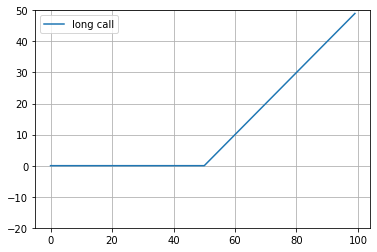

In [2]:
st = np.arange(0,100)
k  = 50
pay_off = [ np.maximum(0,st[i]-k)  for i in range(len(st)) ]

plt.figure()
plt.plot(pay_off,label='long call')
plt.grid()
plt.legend()
plt.ylim(-20,50)
plt.show()

# Debt value = short call + long firm value

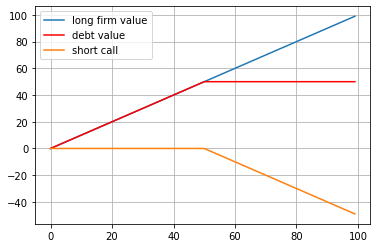

In [3]:
st = np.arange(0,100)
k  = 50
pay_off = [ -np.maximum(0,st[i]-k)  for i in range(len(st)) ]

plt.figure()
plt.plot(st,label='long firm value')
plt.plot(st+pay_off,label='debt value',color='r')
plt.plot(pay_off,label='short call')
plt.grid()
plt.legend()
plt.show()

視賣權為 equity value 的話可以這樣類比

先用 put-call parity 做出來其 equity value & debt value 

recall -  ( put-call parity ) :
$$
S+P = C+PV(k)
$$

原本買權 perspective 中

equity value = C   --> 轉換為賣權 --> S + P - PV(k)

debt value  = S - C -->  轉換為賣權 -->  PV(k) - P

和買權觀點不同的地方在於 , long s 還是在股東權益手上 , 

當 firm value < Debt 時 , 股東會執行賣權 用 debt value（K） 的價格還給債權人 -->(到期時還是要還債)

當 firm value > Debt 時 , 股東不會執行賣權


# Equity value to put option

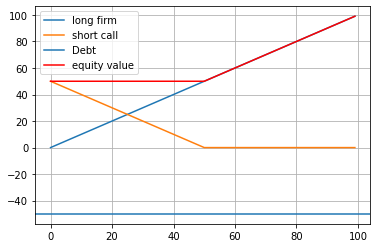

In [4]:
st = np.arange(0,100)
k  = 50
pay_off = [ np.maximum(0,k-st[i])  for i in range(len(st)) ]

plt.figure()
plt.plot(st,label='long firm')
plt.plot(pay_off,label='short call')
plt.axhline(-50,label='Debt')
plt.plot(st+pay_off,label='equity value',color='r')
plt.legend()
plt.grid()
plt.show()

# Debt value to put option

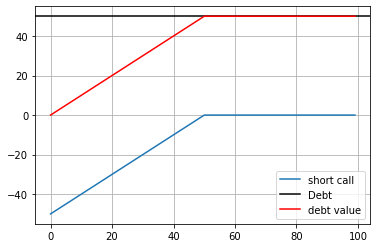

In [5]:
st = np.arange(0,100)
k  = 50
pay_off = [ -np.maximum(0,k-st[i])  for i in range(len(st)) ]
debt_pay_off = [ pay_off[i]+50 for i in range(len(st)) ]

plt.figure()
plt.plot(pay_off,label='short call')
plt.axhline(+50,label='Debt',color='black')
plt.plot(debt_pay_off,label='debt value',color='r')
plt.legend()
plt.grid()
plt.show()

Next we gonna use Monte Carlo Simulation to simulate price 

and use the above ideal to calculate the Default Probability 


In [6]:
def get_price_df(ticker,start,end):
    """
    ticker -- > list 
    start , end --> datetime 
    """
    output_df = pd.DataFrame()
    for stock in ticker :
        df = pdr.get_data_yahoo(stock , start , end)
        price_data = df["Adj Close"]
        output_df[str(stock)] = price_data
    return output_df

def calculation(df,ticker,window):
    u=[]
    var=[]
    drift=[]
    returns_df=df.iloc[::-1]
    returns_df=returns_df.reset_index()
    a=pd.Series(returns_df[str(ticker)]).rolling(window=window)
    for i in a :
        if(i.shape[0]==window):
            log_returns =np.log( 1+i.pct_change().dropna() )
            u .append(  log_returns.mean() )
            var .append( log_returns.var() )
            drift .append( log_returns.mean() - 0.5*( log_returns.var() ) )
        else:
            pass
    u   =  u[::-1]
    var =  var[::-1]
    drift =  drift[::-1]
    return u,var,drift


def MC_simulation_df(df,trial,u,var,drift,ticker,window):
    output_df=pd.DataFrame(index=df.index[window:])
    for i in range(trial) :
        price_path=[ df[str(ticker)][0] ]
        st =df[str(ticker)][0]
        for j in range ( len(u)-2 ) :
            st=st*np.exp( (u[j]-drift[j]) * np.sqrt(1) + np.sqrt(var[j]) * np.sqrt(1) * np.random.normal(0,1))
            price_path.append(st)
        output_df[str(i)]=price_path
    return output_df

def plot_MC_figure(output_df,ticker):
    fig =  plt.figure()
    plt.title("MC simulation for "+str(ticker))
    for i in range(output_df.shape[1]):
        plt.plot(output_df[str(i)].values)
    plt.axhline(60,color='red',label='Debt')
    plt.legend()

-----------------------------------------  MC simulation DataFrame  -----------------------------------------



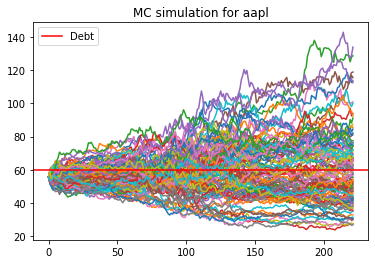

In [7]:
ticker='aapl'
start = dt.datetime(2020,3,22)
end = dt.datetime(2021,3,22)
df = get_price_df([ticker],start,end)
#------------------------------------------ calculate annual parametes ----------------------------------------------------------------------
u,var,drift = calculation(df,ticker,window=30)
#------------------------------------------ MC simulation ----------------------------------------------------------------------
output_df = MC_simulation_df(df,trial=100,u=u,var=var,drift=drift,ticker=ticker,window=30)
print("-----------------------------------------  MC simulation DataFrame  -----------------------------------------\n")
# # #------------------------------------------ plot figure ----------------------------------------------------------------------
plot_MC_figure(output_df,ticker)

Assume Today we have the debt value of 60 and tried to calculate the probability of bankrupt

Loan = 60 

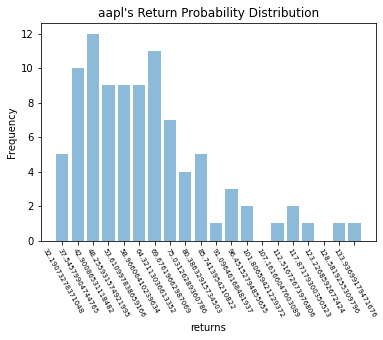

In [8]:
expire_date_price = output_df.iloc[-1]

def find_frequency(returns,res_min,res_max):
    pos = np.where( (returns>= res_min) & (returns < res_max) )
    return returns[pos]

def plot_PDF(df,step):
    returns = df
    returns  = np.sort(returns.values)
    returns_min = np.min(returns)
    returns_max = np.max(returns)
    n = (returns_max - returns_min) / step
    index = []
    frequency = []
    for _ in range(step):
        returns_min+=n
        index.append(returns_min)
        frequency.append( len(find_frequency(returns,returns_min,returns_min+n) ))

    frequency_df = pd.DataFrame()
    frequency_df['index'] = index
    frequency_df["frequency"] = frequency
    frequency_df = frequency_df.sort_values(by='index').reset_index(drop=True)

    plt.figure()
    plt.bar( x=frequency_df.index , height=frequency_df['frequency'].values, align='center', alpha=0.5 , width=0.8)
    plt.xticks(frequency_df.index ,frequency_df["index"].to_list(),rotation=-60,fontsize=7)
    plt.ylabel('Frequency')
    plt.xlabel('returns')
    plt.title(str(ticker)+"'s Return Probability Distribution")
    plt.show()

    return frequency_df

frequency_df = plot_PDF(df=expire_date_price,step=20)

在 Merton Model 中我們都知道

N(d1) 為 避險比率 delta ration 

N(d2) 為 st > k 的機率 --> a.k.a 履約的機率

那如果 Merton Model 類比於公司理財中的話 

N(d2) 為 firm level > debt value 的機率 --> a.k.a probability of not bankrupt 

所以 Default Probability 就是我們的 1-N(d2) = N(-d2)

and d2 = distance to default (DD)

In [10]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.optimize import fsolve
from scipy.stats import norm
import statsmodels.api as sm 

# Giving Equity Value , Equity volatility ,Debt value to solve market value , market volatility 

equation (1) :

$$
E = A * N(d1) - e**(-rt) * N(d2)
$$
equation (2) :
$$
sigma_{equity} = (A/E) * N(d2) * sigma_{asset}
$$


where d1 ,d2 equal ->

$$
d1 =  ( ln(A/D) + (r+0.5*sigma_{a}^2) * T ) / ( sigma_{a} * sqrt(T) )
$$

$$
d2 =  d1 - sigma_{a} * sqrt(T)
$$


note : 

$$
N(d1) = dE/dV_{a}
$$

example --> web source : http://home.lu.lv/~valeinis/lv/seminars/Tetereva_05042012.pdf

In [19]:

d = 33404048
e = 4740291
t = 1
r = 2.32
sigma_e = 0.02396919



class Merton_KMV():
    def __init__(self,D,E,t,r,sigma_e,x):
        self.D = D 
        self.E = E
        self.t = t
        self.r = r 
        self.sigma_e = sigma_e
        self.x = x
    def d1(self,A,D,sigma_a,r,t):
        self.d1_v = ( np.log(A/D) + ( r + sigma_a**2 /2 ) * t ) / ( sigma_a*np.sqrt(t) )
        return self.d1_v 
    def d2(self,A,D,sigma_a,r,t):
        self.d2_v = self.d1_v - sigma_a*np.sqrt(t)
        return self.d2_v 
    def func(self,x):
        sigma_a = x[0]
        a =  x[1] 
        d1_value = self.d1(A=a, D=self.D , sigma_a=sigma_a , r=self.r , t=self.t)
        d2_value = self.d2(A=a, D=self.D , sigma_a=sigma_a , r=self.r , t=self.t)
        return [ (a*norm.cdf(d1_value) - np.exp(-self.r*self.t)*self.D*norm.cdf(d2_value) - self.E) , ((a/self.E) * norm.cdf(d1_value) * sigma_a - self.sigma_e )]
    def fsolve(self):
        root = fsolve( self.func, x0=self.x)
        return root
    
model = Merton_KMV(D=d,E=e,t=t,r=r,sigma_e=sigma_e,x=[ sigma_e , e+d ])
root = model.fsolve()


In [20]:
root

array([1.41624314e-02, 8.02302657e+06])